In [46]:
import pandas as pd
import numpy as np
import os
from scipy.signal import filtfilt
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src/utils')
from load_data import load_metadata, load_trial, load_all_data,load_all_mi_data

In [47]:
base_path = '../data'

metadata = load_metadata(base_path)

train_df = metadata['train']
validation_df = metadata['validation']
test_df = metadata['test']

print(train_df.head())

   id subject_id task  trial_session  trial  label
0   1         S1   MI              1      1   Left
1   2         S1   MI              1      2  Right
2   3         S1   MI              1      3   Left
3   4         S1   MI              1      4   Left
4   5         S1   MI              1      5   Left


In [48]:
base_path = os.path.abspath(os.path.join(os.getcwd(), '../data'))

First_trial = train_df.iloc[0]
trial_data_MI = load_trial(First_trial, 'train', base_path)

print(f"Trial shape: {trial_data_MI.shape}")
print(trial_data_MI.head())

Trial shape: (2250, 18)
            Time             FZ             C3            CZ            C4  \
0  471108.629297  259145.062500  255463.203125  280156.78125  297592.40625   
1  471108.634537  259071.937500  255626.625000  282968.28125  297913.18750   
2  471108.634549  259450.296875  255598.296875  283131.25000  297802.50000   
3  471108.636824  259770.734375  255431.093750  280456.65625  297436.09375   
4  471108.639355  259562.062500  255346.515625  278669.31250  297312.09375   

             PZ            PO7             OZ            PO8      AccX  \
0  268555.25000  255108.156250  232334.953125  239896.906250 -0.156006   
1  269795.59375  255109.765625  232506.515625  240036.203125 -0.143799   
2  269435.43750  255080.796875  232323.593750  239907.625000 -0.137451   
3  267998.68750  255079.453125  232064.765625  239711.656250 -0.133545   
4  267488.87500  255097.703125  232085.765625  239713.000000 -0.132324   

       AccY      AccZ      Gyro1     Gyro2      Gyro3    Batte

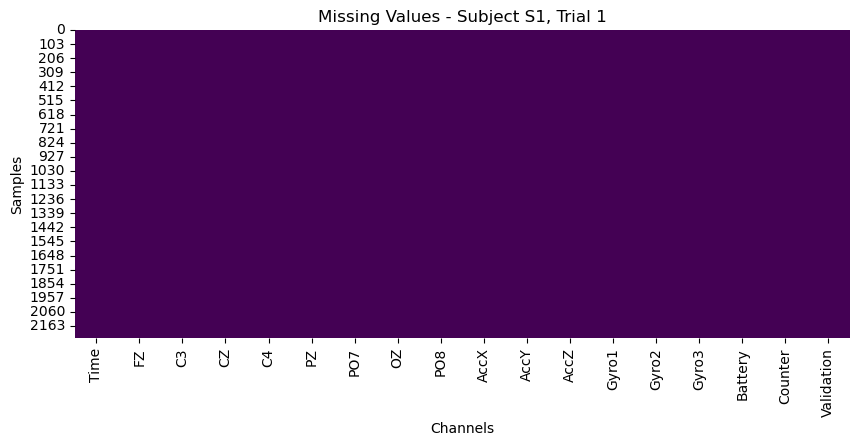

In [49]:
# Plot missing values heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(trial_data_MI.isnull(), cbar=False, cmap='viridis')
plt.title(f"Missing Values - Subject {First_trial['subject_id']}, Trial {First_trial['trial']}")
plt.xlabel("Channels")
plt.ylabel("Samples")
plt.show()

There is no missing Values in the data

In [50]:
def remove_corrupted(df, validation_col='Validation', channels=None):
    """
    Remove rows where validation == 0 and keep only specified channels.
    """
    if channels is None:
        channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    clean_df = df[df[validation_col] != 0]
    clean_df = clean_df[channels].reset_index(drop=True)
    return clean_df

In [51]:
def impute_corrupted(df, validation_col='Validation', channels=None):
    """
    Impute rows where validation == 0 by setting signal values to 0,
    and add a 'corrupted' feature (True if imputed, else False).
    """
    if channels is None:
        channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    result = df.copy()
    # Add 'corrupted' column
    result['corrupted'] = result[validation_col] == 0
    # Set signal values to 0 where validation == 0
    for ch in channels:
        result.loc[result[validation_col] == 0, ch] = 0
    # Keep only channels + 'corrupted'
    result = result[channels + ['corrupted']].reset_index(drop=True)
    return result

In [52]:
channels_to_keep = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']

removed = remove_corrupted(trial_data_MI, channels=channels_to_keep)
imputed = impute_corrupted(trial_data_MI, channels=channels_to_keep)

print("Removed corrupted rows:")
print(removed.head())
print("\nImputed corrupted rows:")
print(imputed.head())

Removed corrupted rows:
              FZ             C3            CZ            C4            PZ  \
0  259145.062500  255463.203125  280156.78125  297592.40625  268555.25000   
1  259071.937500  255626.625000  282968.28125  297913.18750  269795.59375   
2  259450.296875  255598.296875  283131.25000  297802.50000  269435.43750   
3  259770.734375  255431.093750  280456.65625  297436.09375  267998.68750   
4  259562.062500  255346.515625  278669.31250  297312.09375  267488.87500   

             PO7             OZ            PO8  
0  255108.156250  232334.953125  239896.906250  
1  255109.765625  232506.515625  240036.203125  
2  255080.796875  232323.593750  239907.625000  
3  255079.453125  232064.765625  239711.656250  
4  255097.703125  232085.765625  239713.000000  

Imputed corrupted rows:
              FZ             C3            CZ            C4            PZ  \
0  259145.062500  255463.203125  280156.78125  297592.40625  268555.25000   
1  259071.937500  255626.625000  282968.

Removed all rows that has validation number equal to 0 so it is garbage and also only kept the important columns that will affect MI prediction.